# Fine-tuning of facebook/detr-resnet-50 for the detection of basic shapes

High-level overview:
* Load a dataset with images of basic shapes with HuggingFace Datasets
* Transform the dataset so it's compatible with HuggingFace Transformers and the facebook/detr-resnet-50 model
* Fine-tune the facebook/detr-resnet-50 model on the dataset with basic shapes
* Test some inference: detect basic shapes in some test image

At some steps, I added visualizations of the intermediate data so it's easier to understand what's happening.

The dataset is something I generated myself and which can be found at:

* https://github.com/DriesVerachtert/basic_shapes_object_detection_dataset
* https://huggingface.co/datasets/driesverachtert/basic_shapes_object_detection

This way I can be sure that the dataset only consists of RGB images of the same size, that all annotations are
correct and that all bounding boxes fit within the image => no cleaning of the input data needed.

This notebook was mainly developed on a MacBook Pro with an M1 Max, which means PyTorch could use 'MPS' or Metal Performance Shaders for the acceleration of the training. I've tested the code also in a container with JupyterLab on a RHEL 7 machine with V100 GPUs, which means PyTorch could use CUDA. Except for the enormous difference in training speed, there also seems to be a difference in how gradients are handled: when using MPS, gradient clipping does not seem to work, which means gradients sometimes 'explode' and you get a significantly higher training loss in the next step. This can be compensated a bit with a bigger batch size and gradient accumulation. Once I understand a bit better how all this works, I'll try to debug this strange behavior when using MPS.

Useful links:
* https://github.com/facebookresearch/detr
* https://huggingface.co/facebook/detr-resnet-50
* https://huggingface.co/docs/transformers/main/en/tasks/object_detection
* https://huggingface.co/docs/transformers/main/en/model_doc/detr
* https://github.com/Rishit-dagli/CPPE-Dataset

You can easily find similar examples on the internet, but in my personal experience it's quite a challenge to find an example that actually works without errors.

What I would like to add in some future version:
* Get a better understanding of the training parameters like weight decay, learning rate
* Test with distributed training across multiple nodes with multiple GPUs
* Monitor resource usage to find the optimal batch size
* Automatically check after each epoch for overfitting by testing on the test images

The git repository with this code for fine-tuning the model: https://github.com/DriesVerachtert/basic_shapes_object_detection_model

If everything works out as planned, then the fine-tuned model should appear at https://huggingface.co/models/driesverachtert/basic_shapes_object_detection


In [3]:
import typing
import datasets
from PIL.Image import Image
import numpy as np
import albumentations
import numpy as np
import torch
from torch.utils.data import Dataset as TorchDataset
import random
import cv2
import math
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.gridspec import GridSpec
from matplotlib.figure import Figure
import matplotlib.patches as patches
from transformers import AutoImageProcessor, AutoModelForObjectDetection, TrainingArguments, Trainer
from transformers.models.detr.image_processing_detr import DetrImageProcessor
from transformers.models.detr.modeling_detr import DetrForObjectDetection
from transformers.tokenization_utils_base import PreTrainedTokenizerBase
import torchvision.transforms as tvtransforms
import torchvision.transforms.functional as tvfunctional
import torchvision.ops as tvops
from torchvision.utils import make_grid
import torchvision

Set a fixed seed so hopefully results can be repeated:

In [2]:
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

Load the dataset from https://huggingface.co/datasets/driesverachtert/basic_shapes_object_detection :

In [9]:
dataset_name: str = 'driesverachtert/basic_shapes_object_detection'
ds: datasets.DatasetDict = typing.cast(datasets.DatasetDict, datasets.load_dataset(dataset_name))
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 30
    })
})


The HuggingFace Datasets library will download the dataset to ~/.cache/huggingface/datasets/

This dataset is basically a dictionary containing 2 sets of test images:
*  1000 images in the 'train' split
* 30 images in the 'test' split

Let's list info about the features:

In [4]:
def print_features_of_train_dataset(ds: datasets.DatasetDict):
    train_ds: datasets.Dataset = ds['train']

    for key in train_ds.features:
        print(key + ": " + str(train_ds.features[key]))

    print("\n'objects' in more detail:")
    objects_features: datasets.Sequence = typing.cast(datasets.Sequence, train_ds.features['objects'])
    for key in objects_features.feature:
        print(key + ": " + str(objects_features.feature[key]))


print_features_of_train_dataset(ds)

image_id: Value(dtype='int64', id=None)
image: Image(decode=True, id=None)
width: Value(dtype='int32', id=None)
height: Value(dtype='int32', id=None)
objects: Sequence(feature={'id': Value(dtype='int64', id=None), 'area': Value(dtype='int64', id=None), 'bbox': Sequence(feature=Value(dtype='float32', id=None), length=4, id=None), 'category': ClassLabel(names=['Square', 'Circle', 'Triangle'], id=None)}, length=-1, id=None)

'objects' in more detail:
id: Value(dtype='int64', id=None)
area: Value(dtype='int64', id=None)
bbox: Sequence(feature=Value(dtype='float32', id=None), length=4, id=None)
category: ClassLabel(names=['Square', 'Circle', 'Triangle'], id=None)


Each image has an image_id, a width, and a height. Each image also has a list of 'objects' or annotations with labels. Each of those objects has its own id, a bounding box, a category ID and the area of the bounding box.

The bounding boxes use the x,y,w,h format: x and y coordinates of the top left corner, width and height. Note that the model uses cx,cy,w,h internally instead: x and y coordinate of the center of the bounding box, width and height.

Now store the labels in a list for convenience, and show all info about 1 of the images:

In [6]:
category_names: typing.List[str] = typing.cast(datasets.ClassLabel, ds['train'].features['objects'].feature['category']).names

Show all info about 1 of the images:

In [7]:
def print_info_single_image(img_data: typing.Dict) -> None:
    image_id: int = img_data['image_id']
    image: Image = img_data['image']
    width: int = img_data['width']
    height: int = img_data['height']
    object_id: typing.List[int] = img_data['objects']['id']
    object_area: typing.List[int] = img_data['objects']['area']
    object_bbox: typing.List[typing.List[int]] = img_data['objects']['bbox']
    object_category: typing.List[int] = img_data['objects']['category']
    print(f"Image with id {image_id}, width {width} and height {height} and {len(object_id)} objects:")
    for i, id in enumerate(object_id):
        cat_id: int = object_category[i]
        cat_name: str = category_names[cat_id]
        print(f"object {i} with id {id}, area {object_area[i]}, bbox {object_bbox[i]}, category {cat_id}: {cat_name}")

def print_info_of_image_0_of_train():
    img_data: typing.Dict = ds["train"][0]
    print(img_data)
    print_info_single_image(img_data)

print_info_of_image_0_of_train()

{'image_id': 0, 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=800x800 at 0x2BA0D0D50>, 'width': 800, 'height': 800, 'objects': {'id': [0, 1, 2], 'area': [10000, 10000, 5000], 'bbox': [[509.0, 593.0, 100.0, 100.0], [286.0, 507.0, 100.0, 100.0], [291.0, 412.0, 100.0, 50.0]], 'category': [0, 1, 2]}}
Image with id 0, width 800 and height 800 and 3 objects:
object 0 with id 0, area 10000, bbox [509.0, 593.0, 100.0, 100.0], category 0: Square
object 1 with id 1, area 10000, bbox [286.0, 507.0, 100.0, 100.0], category 1: Circle
object 2 with id 2, area 5000, bbox [291.0, 412.0, 100.0, 50.0], category 2: Triangle


The location of the shapes is different in each of the images, but each of the images has the same number of objects / bounding boxes:
* 1 bounding box containing a square
* 1 bounding box containing a circle
* 1 bounding box containing a triangle

Let's display some of the images in a grid:

/Users/verachte/git/github/basic_shapes_object_detection_model/venv/lib/python3.11/site-packages/torchvision/utils.py:223: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


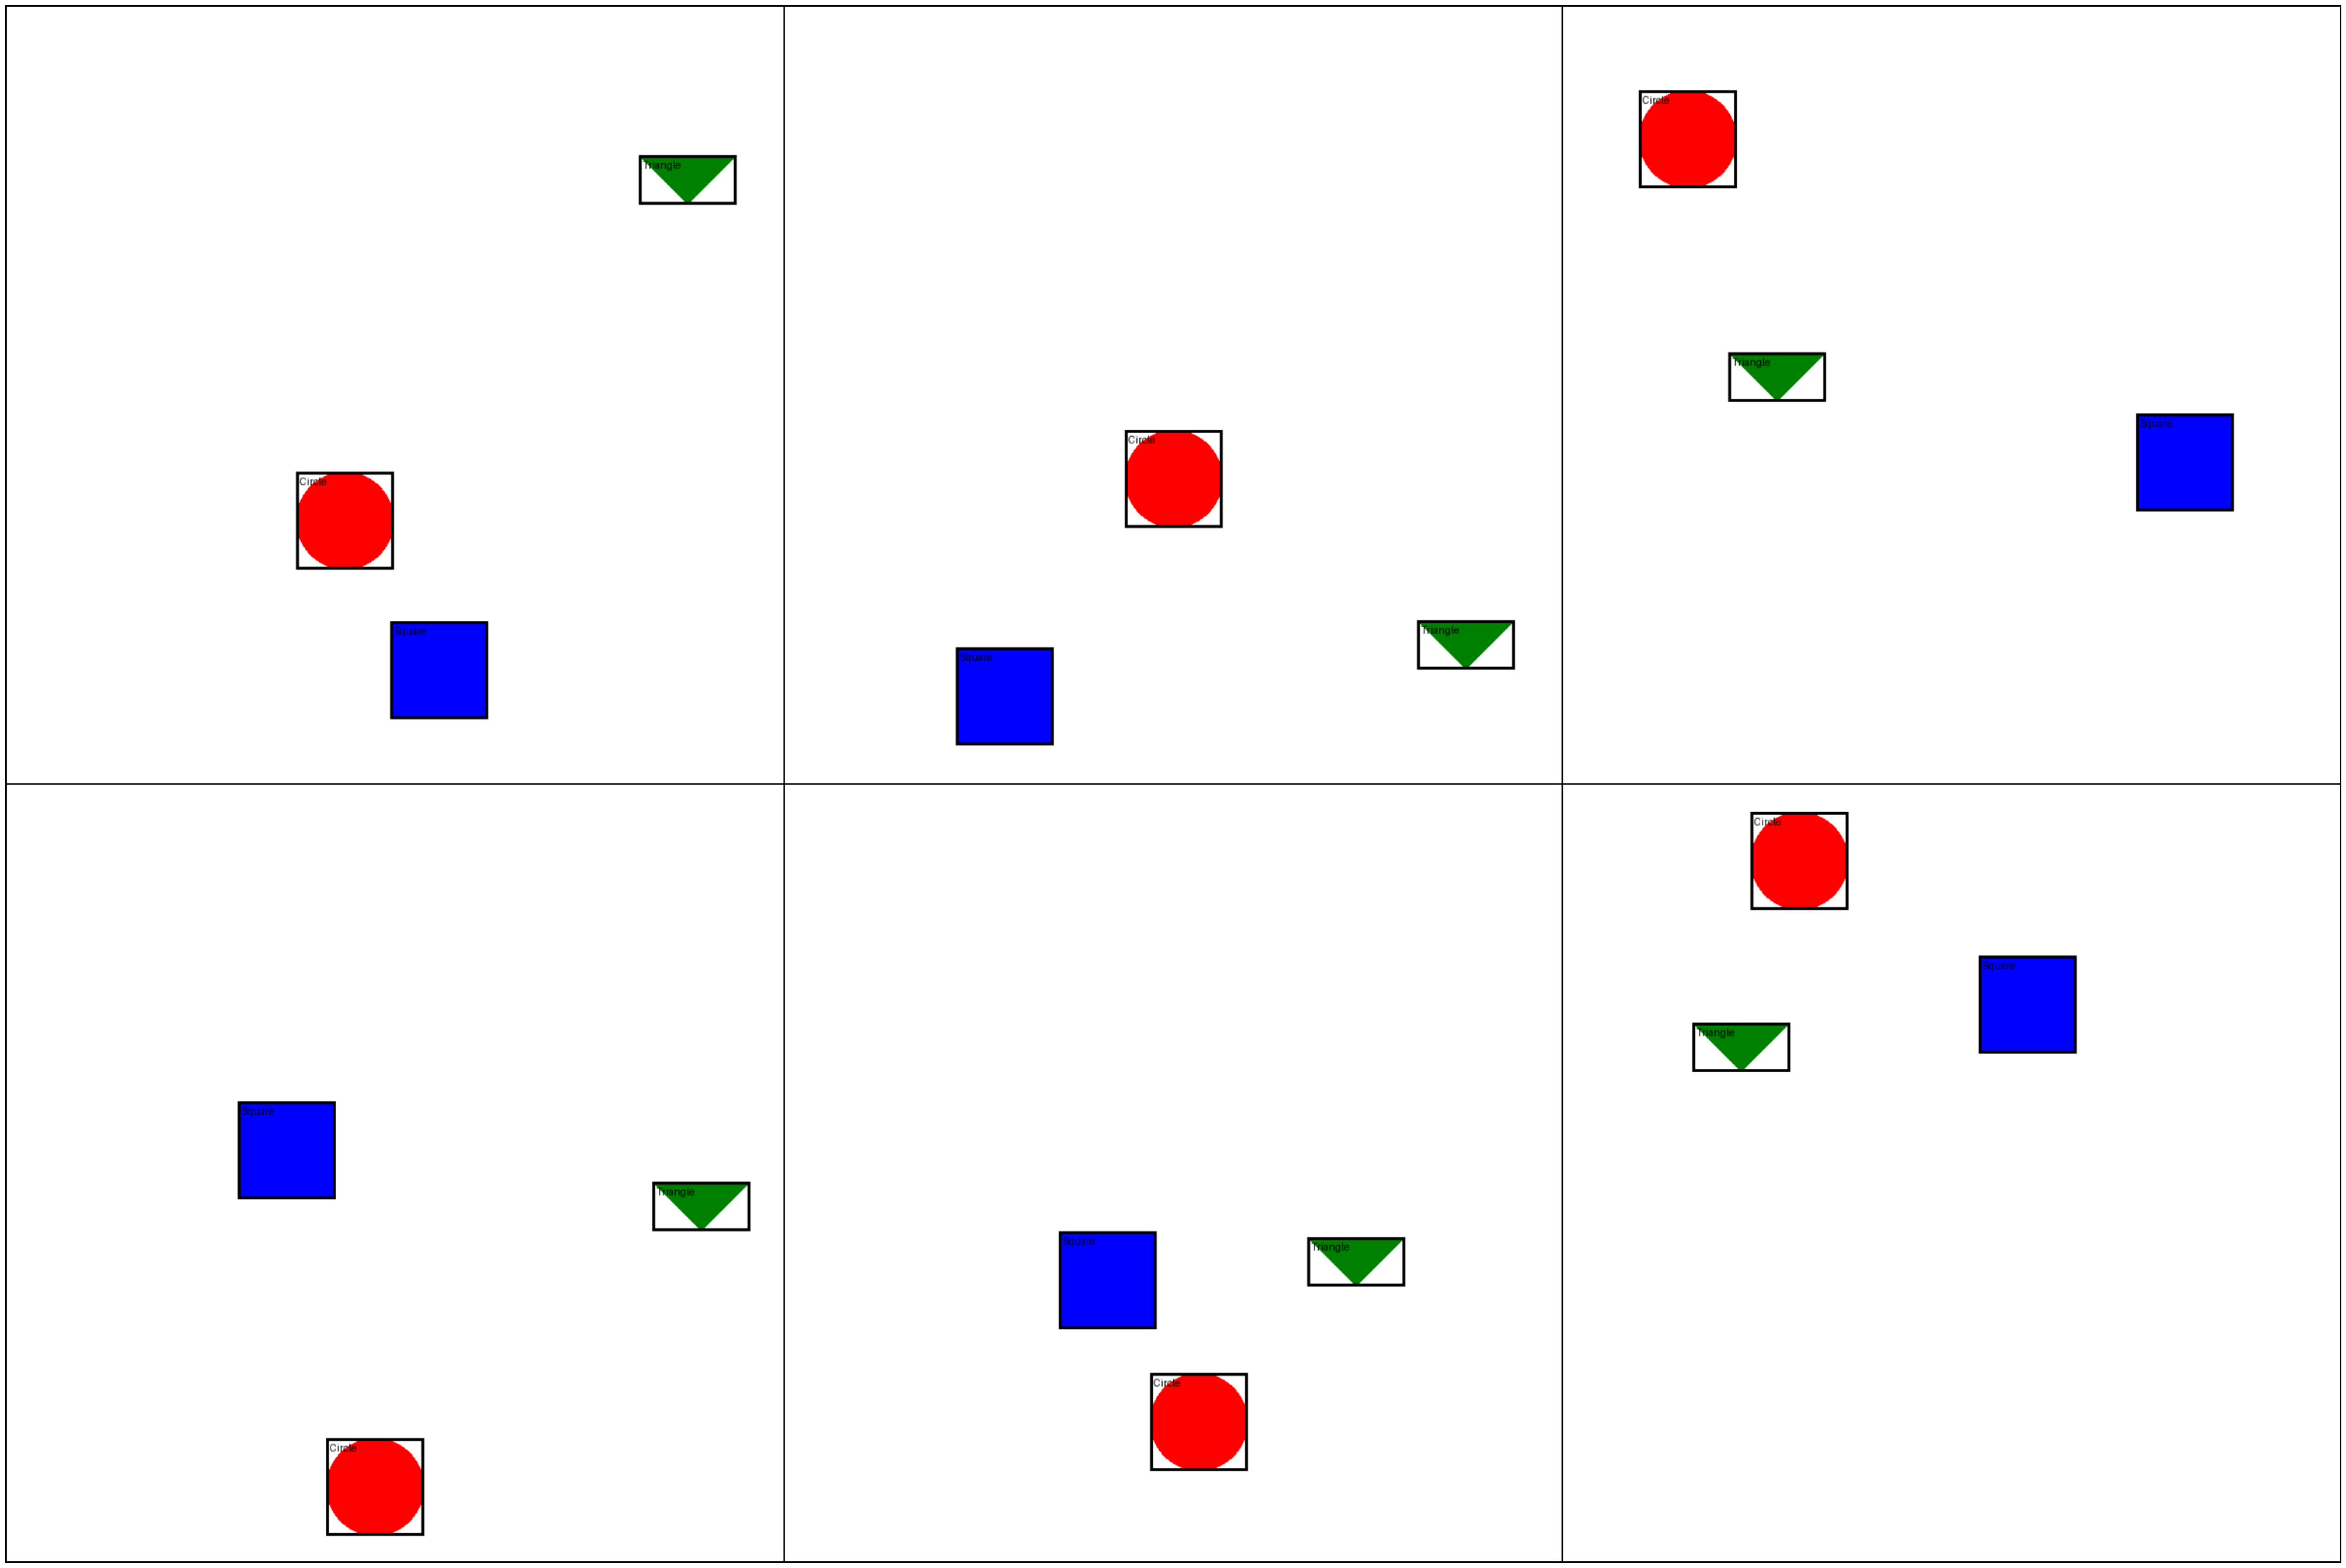

In [10]:
def create_single_image_with_annotations(img_data: typing.Dict, font: str = "Verdana", box_width: int = 1, font_size: int = 10) -> Image:
    """ Create an image with the bounding boxes and labels applied """
    img_as_tensor: torch.Tensor = tvfunctional.pil_to_tensor(img_data['image'])
    # draw_bounding_boxes expects boxes in xmin, ymin, xmax, ymax format,
    # while this dataset uses x,y, width, height. => torchvision has some conversion function
    boxes: torch.Tensor = tvops.box_convert(torch.tensor(img_data['objects']['bbox']), 'xywh', 'xyxy')
    labels: typing.List[str] = [category_names[i] for i in  img_data['objects']['category']]
    image_with_boxes: torch.Tensor = torchvision.utils.draw_bounding_boxes(image=img_as_tensor,
                                        boxes=boxes,
                                        labels=labels,
                                        colors='black',
                                        fill=False,
                                        width=box_width,
                                  
                                        font_size=font_size)
    return tvfunctional.to_pil_image(image_with_boxes)


def show_images_in_grid(img_data_list: datasets.Dataset):
    ''' Show a bunch of images with their annotations in a grid with 2 images per row '''
    images: typing.List[Image] = [create_single_image_with_annotations(typing.cast(typing.Dict, img_data), font_size=15, box_width=3) for img_data in img_data_list]
    # Transform the images to tensor
    # TODO: convert create_single_image_with_annotations also to such a transformation
    transform = tvtransforms.Compose([
        tvtransforms.Resize((1024, 1024)),
        tvtransforms.ToTensor()
    ])
    tensors = [transform(img) for img in images]
    # combine the images into 1 big tensor
    batch = torch.stack(tensors)
    # make a grid of images with 2 images per row
    grid_img = make_grid(batch, nrow=3)

    num_rows: int = math.ceil(float(len(img_data_list))/3.)
    width_height_per_image: int = 15
    plt.figure(figsize=(width_height_per_image*3, num_rows*width_height_per_image))
    
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
    plt.show()

def show_some_images():
    some_images: datasets.Dataset = ds['train'].select(range(20,26))
    show_images_in_grid(some_images)

show_some_images()


When working on a real dataset, there's often some cleanup to be done:
* Check if all the images are valid and use RGB without transparancy
* Check if all bounding boxes are located within the boundaries of the image

In this case, that's not needed as that was already checked when the dataset was created.

Also often it's useful to do image augmentation with for example the albumentations library, but that's overkill for this dataset.

Create the AutoImageProcessor which will deal with the pixel values and masks and so on:

In [11]:
image_processor_checkpoint = "facebook/detr-resnet-50"
image_processor: DetrImageProcessor = AutoImageProcessor.from_pretrained(image_processor_checkpoint)
print(image_processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


DetrImageProcessor {
  "_valid_processor_keys": [
    "images",
    "annotations",
    "return_segmentation_masks",
    "masks_path",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "do_convert_annotations",
    "image_mean",
    "image_std",
    "do_pad",
    "format",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_convert_annotations": true,
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "format": "coco_detection",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "DetrImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 1333,
    "shortest_edge": 800
  }
}



See https://huggingface.co/facebook/detr-resnet-50 for details about the image processor.

Now we'll convert the images in the format that the model expects. The issue:

The annotations are currently structured in a way which doesn't work with the HuggingFace DETR model, see https://huggingface.co/docs/transformers/model_doc/detr . At the moment, info about a single image and all its annotations (bounding boxes and labels) are stored in multiple lists, while DETR expects a list containing a single dict for each annotation separately. Suppose the dataset has an image with 5 annotations, then this has to be converted into 5 dicts for each annotation separately.

The dataset contains for each image:
- A list of bounding boxes
- A list of category IDs / labels for each of the bounding boxes
- Area sizes for each of the bounding boxes

This needs to become:
- A dict for each object, containing:
  - a single bounding box
  - a category ID
  - an area size

A call to albumentations is kept, but at the moment it isn't used to augment the dataset.

In [7]:
albumentations_transform = albumentations.Compose(
  transforms=[],
  bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]))

def transform_for_detr(batch: typing.Dict):
    """ transform a batch of images to detr format
    batch: a dict, with elements like image_id, image, width.. and each value is a list.
    That list might contain the info of just 1 image, but it can also be of more"""
    # first transform to lists
    images: typing.List[np.ndarray] = []
    annotations: typing.List[typing.Dict] = []

    # TODO use albumentations to create multiple transformed images from a single dataset image
    for i, image_id in enumerate(batch['image_id']):
      objects = batch['objects'][i]
      image_orig = np.array(batch['image'][i])
      image_transformed = albumentations_transform(image=image_orig, bboxes=objects["bbox"], category=objects["category"])
      images.append(image_transformed['image'])
      bboxes = image_transformed['bboxes']
      categories = image_transformed['category']

      # TODO we could probably drop those: not used, and they should also be updated if certain albumentations transformations
      # are used that resize or crop the image
      areas = objects['area']
      width = batch['width'][i]
      height = batch['height'][i]

      annotations_of_single_image = []
      for bbox, category_id, area in zip(bboxes, categories, areas):
         single_annotation_of_image = {}
         single_annotation_of_image['category_id'] = category_id
         single_annotation_of_image['bbox'] = bbox
         single_annotation_of_image['area'] = area # probably not needed
         single_annotation_of_image['image_id'] = image_id # probably not needed
         annotations_of_single_image.append(single_annotation_of_image)

      annotations_of_image = {}
      annotations_of_image['image_id'] = image_id
      annotations_of_image['annotations'] = annotations_of_single_image
      annotations.append(annotations_of_image)

    # convert the preprocessed data now into the format that the model uses internally
    return image_processor(images=images, annotations=annotations, return_tensors="pt")

Convert a single image and check how it looks like:

In [10]:
print(ds["train"].with_transform(transform_for_detr)[0])

{'pixel_values': tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         ...,
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

        [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         ...,
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

        [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2

The result of the transformation is a dict containing:
* pixel_values: a Tensor
* pixel_mask: a Tensor
* labels: a 'BatchFeature'

Store the entries in the dictionary as separate values to have a closer look:

In [11]:
from transformers.image_processing_utils import BatchFeature

single_transformed_image: typing.Dict[str,typing.Any] = ds["train"].with_transform(transform_for_detr)[0]

single_transformed_image_pixel_values: torch.Tensor = single_transformed_image['pixel_values']
single_transformed_image_pixel_mask: torch.Tensor = single_transformed_image['pixel_mask']
single_transformed_image_labels: BatchFeature = single_transformed_image['labels']

The pixel_values are normalized: instead of pixel values between 0 and 1 or between 0 and 255, you get values with an average of 0 and both negative and positive values. Although normalized, matplotlib does not seem to have any issues to display the image (I didn't expect that to work to be honest).

Note how the rectangles of the boxes are drawn: after the transformation, the bounding boxes are in cx,cy,wh format: the x,y coordinates of the center of the bounding box, width and height. This is the format that the model uses internally. Also the values are scaled to 0-1 => a coordinate (0,0) corresponds to the top left corner of the image and (1,1) corresponds to the bottom right corner.

The input images are of size 800x800, which is in the range of sizes that the model can use. This means that the image processor does not need to resize the image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pixel_values is a tensor with shape torch.Size([3, 800, 800])
Minimum value -2.1179039478302
Maximum value 2.640000104904175
width: 800, height: 800
tensor([0.6988, 0.8037, 0.1250, 0.1250])
tensor([0.4200, 0.6963, 0.1250, 0.1250])
tensor([0.4263, 0.5462, 0.1250, 0.0625])


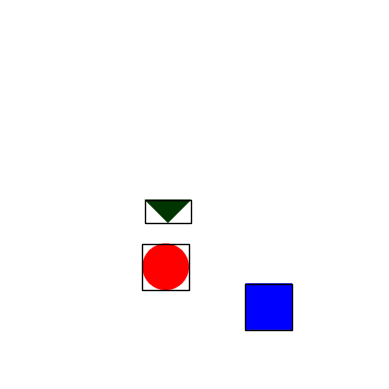

In [12]:
def show_pixel_values(pixel_values: torch.Tensor, boxes: torch.Tensor):
    print(f"pixel_values is a tensor with shape {pixel_values.shape}")
    print(f"Minimum value {pixel_values.min()}")
    print(f"Maximum value {pixel_values.max()}")
    
    # to show a tensor as an image, the RGB values should be the last dimension
    image: np.ndarray = pixel_values.permute(1, 2, 0).numpy()
    width: int = image.shape[0]
    height: int = image.shape[1]
    print(f"width: {width}, height: {height}")
    _, ax = plt.subplots()
    # Show the image
    ax.imshow(image)
    ax.axis('off')
    for box in boxes:
        print(box)
        # cx,cy,w,h format!
        bw: int = int(box[2]*width)
        bh: int = int(box[3]*height)
        bx: int = int(box[0]*width - bw/2)
        by: int = int(box[1]*height - bh/2)
        rect = patches.Rectangle((bx, by), bw, bh, linewidth=1, edgecolor='black', facecolor='none')
        ax.add_patch(rect)
    plt.show()

show_pixel_values(single_transformed_image_pixel_values, single_transformed_image_labels['boxes'])

The pixel_mask seems to contain only '1' values. As far as I understand, pixel masks are only used for segmentation tasks and not for object detection tasks.

pixel_mask is a tensor with shape torch.Size([800, 800])
Minimum value 1
Maximum value 1


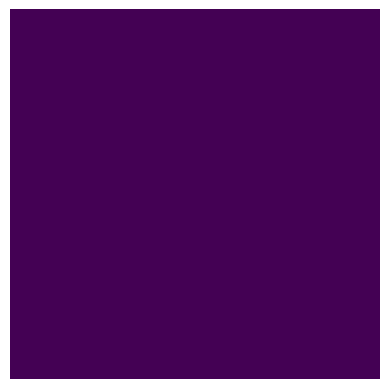

In [13]:
def show_pixel_mask(pixel_mask: torch.Tensor):
    print(f"pixel_mask is a tensor with shape {pixel_mask.shape}")
    print(f"Minimum value {pixel_mask.min()}")
    print(f"Maximum value {pixel_mask.max()}")

    image = pixel_mask.numpy()
    # Show the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

show_pixel_mask(single_transformed_image_pixel_mask)

The labels object behaves like a dict with the following keys:
* size: 
* image_id
* class_labels
* boxes: bounding boxes, but scaled to values between 0 and 1
* area: sizes of the bounding boxes
* iscrowd: 0 as we're not classifying groups of objects
* orig_size: original size of the image

In [14]:
for k,v in single_transformed_image_labels.items():
    print(f"{k}:{v}")

size:tensor([800, 800])
image_id:tensor([0])
class_labels:tensor([0, 1, 2])
boxes:tensor([[0.6988, 0.8037, 0.1250, 0.1250],
        [0.4200, 0.6963, 0.1250, 0.1250],
        [0.4263, 0.5462, 0.1250, 0.0625]])
area:tensor([10000., 10000.,  5000.])
iscrowd:tensor([0, 0, 0])
orig_size:tensor([800, 800])


Now transform all of the images, and store it again within the dataset as a new 'split':

In [8]:
ds["train_transformed"] = ds["train"].with_transform(transform_for_detr)
ds["test_transformed"] = ds["test"].with_transform(transform_for_detr)

Download the model from HuggingFace Hub which we'll use for finetuning:

In [9]:
id2label: typing.Dict[int, str] = {i: cat for i, cat in enumerate(category_names)}
label2id: typing.Dict[str, int] = {cat: i for i, cat in enumerate(category_names)}

model: DetrForObjectDetection = AutoModelForObjectDetection.from_pretrained(image_processor_checkpoint,
    id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)

print(model)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

Now let's train the model on the 'train' images.

Some notes on the training arguments:
* A small batch size gives bad results, especially when using MPS. The model gets fine-tuned way faster with a bigger batch. The maximum depends on your hardware though.
* According to some documentation, the learning rate should be between 1e-3 and 1e-5.
* According to that same documentation, the weight decay should be between 1e-2 and 1e-4.
* The default value for max_grad_norm should be 1.0 according to the documentation, but on MPS this gradient clipping might not be working. Also with a lower value of 0.5, the training algorithm would sometimes calculate very high gradients ('exploding' gradients) which nullifies quite a lot of the training.
* To avoid high gradients, I added the gradient_accumulation_steps=4, which should result in a more 'smooth' learning, at the cost of slower learning.

In [12]:
finetuned_model_dir: str = 'facebook-detr-resnet-50-finetuned-for-basic-shapes'

training_args: TrainingArguments = TrainingArguments(
    output_dir=finetuned_model_dir,
    overwrite_output_dir=True,
    do_train=True,
    per_device_train_batch_size=16,
    num_train_epochs=30,
    max_grad_norm=0.5,
    gradient_accumulation_steps=4,
    fp16=False, # only available on GPUs
    save_steps=50,
    logging_steps=30,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
)

To be able to train with batches, you need a 'collator' method which tranforms a list of dicts into a single dictionary.

In [11]:
def batch_collator(batch_input: typing.List[typing.Dict]) -> typing.Dict:
    """  combine data of multiple images into 1 batch """
    pixel_values: typing.List = [item["pixel_values"] for item in batch_input]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch_input]
    batch_retval = {}
    batch_retval["pixel_values"] = encoding["pixel_values"]
    batch_retval["pixel_mask"] = encoding["pixel_mask"]
    batch_retval["labels"] = labels
    return batch_retval

Now the actual training or fine tuning of the model on the data that was prepared...

A first training run:

In [18]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=batch_collator,
    #train_dataset=typing.cast(TorchDataset, ds["train_transformed"].select([0])),
    train_dataset=typing.cast(TorchDataset, ds["train_transformed"]),
    tokenizer=typing.cast(PreTrainedTokenizerBase, image_processor),
)

trainer.train()
trainer.save_model(finetuned_model_dir)

/Users/verachte/git/github/basic_shapes_object_detection_model/venv/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
  7%|▋         | 30/450 [05:06<1:11:23, 10.20s/it]

{'loss': 1.5952, 'grad_norm': 18.430248260498047, 'learning_rate': 9.333333333333334e-06, 'epoch': 1.9}


 13%|█▎        | 60/450 [10:11<1:06:01, 10.16s/it]

{'loss': 1.2458, 'grad_norm': 7.9395222663879395, 'learning_rate': 8.666666666666668e-06, 'epoch': 3.81}


 20%|██        | 90/450 [15:16<1:00:57, 10.16s/it]

{'loss': 1.05, 'grad_norm': 9.386923789978027, 'learning_rate': 8.000000000000001e-06, 'epoch': 5.71}


 27%|██▋       | 120/450 [20:20<55:51, 10.15s/it]  

{'loss': 0.9644, 'grad_norm': 18.014511108398438, 'learning_rate': 7.333333333333333e-06, 'epoch': 7.62}


 33%|███▎      | 150/450 [25:24<50:51, 10.17s/it]

{'loss': 0.9236, 'grad_norm': 13.595471382141113, 'learning_rate': 6.666666666666667e-06, 'epoch': 9.52}


 40%|████      | 180/450 [30:29<45:21, 10.08s/it]

{'loss': 0.9021, 'grad_norm': 9.90170955657959, 'learning_rate': 6e-06, 'epoch': 11.43}


 47%|████▋     | 210/450 [35:33<39:46,  9.94s/it]

{'loss': 0.888, 'grad_norm': 9.105988502502441, 'learning_rate': 5.333333333333334e-06, 'epoch': 13.33}


 53%|█████▎    | 240/450 [40:32<34:41,  9.91s/it]

{'loss': 0.8788, 'grad_norm': 12.8645601272583, 'learning_rate': 4.666666666666667e-06, 'epoch': 15.24}


 60%|██████    | 270/450 [45:30<29:26,  9.81s/it]

{'loss': 0.8677, 'grad_norm': 7.014223575592041, 'learning_rate': 4.000000000000001e-06, 'epoch': 17.14}


 67%|██████▋   | 300/450 [50:28<24:17,  9.72s/it]

{'loss': 0.8531, 'grad_norm': 8.655557632446289, 'learning_rate': 3.3333333333333333e-06, 'epoch': 19.05}


 73%|███████▎  | 330/450 [55:29<20:02, 10.02s/it]

{'loss': 0.845, 'grad_norm': 11.849687576293945, 'learning_rate': 2.666666666666667e-06, 'epoch': 20.95}


 80%|████████  | 360/450 [1:00:29<15:02, 10.03s/it]

{'loss': 0.8315, 'grad_norm': 15.206281661987305, 'learning_rate': 2.0000000000000003e-06, 'epoch': 22.86}


 87%|████████▋ | 390/450 [1:05:31<10:14, 10.25s/it]

{'loss': 0.8244, 'grad_norm': 5.940078258514404, 'learning_rate': 1.3333333333333334e-06, 'epoch': 24.76}


 93%|█████████▎| 420/450 [1:10:37<05:04, 10.14s/it]

{'loss': 0.817, 'grad_norm': 8.530083656311035, 'learning_rate': 6.666666666666667e-07, 'epoch': 26.67}


100%|██████████| 450/450 [1:15:43<00:00, 10.38s/it]

{'loss': 0.8127, 'grad_norm': 10.025440216064453, 'learning_rate': 0.0, 'epoch': 28.57}


100%|██████████| 450/450 [1:15:44<00:00, 10.10s/it]


{'train_runtime': 4544.746, 'train_samples_per_second': 6.601, 'train_steps_per_second': 0.099, 'train_loss': 0.9533011627197265, 'epoch': 28.57}


My macbook was hot and noisy for +/- 75 minutes and managed to reach a loss of 0.8. I did a brief test on some images and the results were quite bad.

It's quite easy to train a HuggingFace model for some extra epochs: just call the train() method again.

In [22]:
trainer.train()
trainer.save_model(finetuned_model_dir)

  7%|▋         | 30/450 [05:25<1:14:53, 10.70s/it]

{'loss': 0.7911, 'grad_norm': 11.29993724822998, 'learning_rate': 9.333333333333334e-06, 'epoch': 1.9}


 13%|█▎        | 60/450 [10:55<1:12:58, 11.23s/it]

{'loss': 0.7312, 'grad_norm': 8.157944679260254, 'learning_rate': 8.666666666666668e-06, 'epoch': 3.81}


 20%|██        | 90/450 [16:18<1:03:40, 10.61s/it]

{'loss': 0.7689, 'grad_norm': 32.39998245239258, 'learning_rate': 8.000000000000001e-06, 'epoch': 5.71}


 27%|██▋       | 120/450 [21:40<58:22, 10.61s/it]  

{'loss': 0.7981, 'grad_norm': 17.85107421875, 'learning_rate': 7.333333333333333e-06, 'epoch': 7.62}


 33%|███▎      | 150/450 [27:01<53:33, 10.71s/it]

{'loss': 0.7246, 'grad_norm': 15.627989768981934, 'learning_rate': 6.666666666666667e-06, 'epoch': 9.52}


 40%|████      | 180/450 [32:23<48:14, 10.72s/it]

{'loss': 0.758, 'grad_norm': 22.889949798583984, 'learning_rate': 6e-06, 'epoch': 11.43}


 47%|████▋     | 210/450 [37:54<45:20, 11.33s/it]

{'loss': 0.7098, 'grad_norm': 16.97774887084961, 'learning_rate': 5.333333333333334e-06, 'epoch': 13.33}


 53%|█████▎    | 240/450 [43:31<39:07, 11.18s/it]

{'loss': 0.6377, 'grad_norm': 16.335668563842773, 'learning_rate': 4.666666666666667e-06, 'epoch': 15.24}


 60%|██████    | 270/450 [48:57<31:30, 10.50s/it]

{'loss': 0.6, 'grad_norm': 8.778648376464844, 'learning_rate': 4.000000000000001e-06, 'epoch': 17.14}


 67%|██████▋   | 300/450 [54:17<25:58, 10.39s/it]

{'loss': 0.5867, 'grad_norm': 14.12330150604248, 'learning_rate': 3.3333333333333333e-06, 'epoch': 19.05}


 73%|███████▎  | 330/450 [59:41<21:27, 10.73s/it]

{'loss': 0.5899, 'grad_norm': 11.55584716796875, 'learning_rate': 2.666666666666667e-06, 'epoch': 20.95}


 80%|████████  | 360/450 [1:05:05<16:11, 10.79s/it]

{'loss': 0.5794, 'grad_norm': 17.078821182250977, 'learning_rate': 2.0000000000000003e-06, 'epoch': 22.86}


 87%|████████▋ | 390/450 [1:10:28<10:45, 10.75s/it]

{'loss': 0.5763, 'grad_norm': 11.1632719039917, 'learning_rate': 1.3333333333333334e-06, 'epoch': 24.76}


 93%|█████████▎| 420/450 [1:15:50<05:21, 10.71s/it]

{'loss': 0.5886, 'grad_norm': 24.865928649902344, 'learning_rate': 6.666666666666667e-07, 'epoch': 26.67}


100%|██████████| 450/450 [1:21:10<00:00, 10.73s/it]

{'loss': 0.5778, 'grad_norm': 33.49820327758789, 'learning_rate': 0.0, 'epoch': 28.57}


100%|██████████| 450/450 [1:21:12<00:00, 10.83s/it]


{'train_runtime': 4872.5178, 'train_samples_per_second': 6.157, 'train_steps_per_second': 0.092, 'train_loss': 0.6678599082099067, 'epoch': 28.57}


After another +/- 80 minutes, the loss went down to +/- 0.58. At this level, it seems to be able to detect most of the objects on a test image, but the confidence level is still quite low. Let's now test the image.

When you want to use the model for some inference, to detect some shapes on a test image, you have
to make sure the correct device memory is used. Otherwise you get errors about input data being located
in CPU memory but weights stored in the MPS memory for example.

A method to select the correct device which should be used during inference:

In [5]:
def get_torch_device() -> torch.device:
    if torch.cuda.is_available():
        print("cuda is available: using GPU(s)")
        return torch.device("cuda")
    if torch.backends.mps.is_available():
        print("MPS is available: using Apple Silicon GPU")
        return torch.device("mps:0")
    print("No CUDA or MPS available: using the CPU")
    return torch.device("cpu")

print("get_torch_device() returns: " + str(get_torch_device()))

MPS is available: using Apple Silicon GPU
get_torch_device() returns: mps:0


Next, let's define a generic method which can be used to detect objects with any model. This way we can compare the fine-tuned model with the original model.

Inference consists of +/- the following steps:
* preprocess the image: it's converted to tensors, with pixel values with an average of 0 (similar to what happened in the preprocessing for training)
* run the model on the preprocessed image
* postprocess the result, keep only the objects and their bounding boxes & labels that were detected with a confidence above a certain threshold

Note that these steps are designed to work on multiple images concurrently, which means we'll have to wrap the single image in some array.

The following method 'detect_objects' does the following:
* Make sure the model is located in the correct device memory
* The 3 inference steps listed above
* Print some info about the objects found: the confidence values, the bounding boxes and the labels
* Show the input image with the bounding boxes applied.

In this case, the bounding boxes are in x1,y1,x2,y2 format: the coordinates of the top left pixel and the bottom right pixel.

Sadly Python typing has some issues here, as the models use types like 'DeviceLikeType' and 'TensorType' which does not seem to match the actual types.

In [6]:
def detect_objects(img: Image, some_image_processor: DetrImageProcessor, some_model: DetrForObjectDetection, threshold=0.4) -> typing.Dict:
    torch_device: torch.device = get_torch_device()
    # move the model to the GPU memory if it's available
    some_model = some_model.to(torch_device)

    with torch.no_grad(): # gradients aren't needed for inference
        preprocessed = some_image_processor(img, return_tensors='pt')
        preprocessed = preprocessed.to(torch_device)
    model_output = some_model(**preprocessed)
    # tensor of the size of each image, in this case just the single image
    # => we end up with a tensor with just 1 array containing an array with the height and width
    target_sizes = torch.tensor([[img.height, img.width]])
    target_sizes = torch.tensor([img.size[::-1]])
    result_list: typing.List[typing.Dict] = some_image_processor.post_process_object_detection(outputs=model_output, target_sizes=target_sizes, threshold=threshold)

    # We get a list with a dict for each image. We only gave it 1 image, so there's only a dict at index 0.
    result: typing.Dict = result_list[0]
    # 'result' contains all the info about the detected objects such as bounding boxes and labels

    # Show the original image
    np_image = np.array(img)
    width = np_image.shape[0]
    height = np_image.shape[1]
    print(f"width: {width}, height: {height}")
    _, ax = plt.subplots()
    ax.imshow(np_image)
    ax.axis('off')

    if len(result['scores']) == 0:
        print(f"Nothing detect at threshold level {threshold}")
    else:
        print(f"Number of detected objects at threshold level {threshold}: {len(result['scores'])}")

    # For each of the detected objects: print some info and also add a rectangle on the shown image
    for score, category_id_tensor, box in zip(result['scores'], result['labels'], result['boxes']):
        # convert the tensor containing just the single label id into an int
        cat_id: int = int(category_id_tensor)
        category_name: str = some_model.config.id2label[cat_id]
        # convert the tensor values of the bounding box to regular python ints
        x = int(box[0])
        y = int(box[1])
        w = int(box[2]-box[0])
        h = int(box[3]-box[1])
        print(f"Category {category_name} with score {score:.2f} at bounding box {x},{y},{w},{h}")
        rect = patches.Rectangle((x,y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()
    return result


First test: use the model which was fine-tuned on a MacBook Air with MPS for +/- two and a half hours on an image in the 'test' set. This image was not used for training.


MPS is available: using Apple Silicon GPU
width: 800, height: 800
Number of detected objects at threshold level 0.3: 3
Category Triangle with score 0.40 at bounding box 194,400,91,49
Category Square with score 0.34 at bounding box 152,94,100,104
Category Circle with score 0.38 at bounding box 331,133,100,101


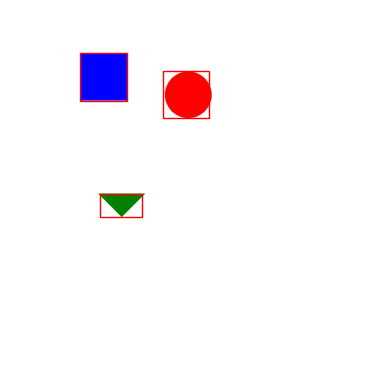

In [19]:
def test_detect_objects_in_first_test_image_with_finetuned_model_on_mps():
    inference_image_processor: DetrImageProcessor = AutoImageProcessor.from_pretrained(finetuned_model_dir)
    inference_model: DetrForObjectDetection = AutoModelForObjectDetection.from_pretrained(finetuned_model_dir)
    test_img: Image = ds['test'][0]['image']
    detection_result: typing.Dict = detect_objects(test_img, inference_image_processor, inference_model, threshold=0.3)

test_detect_objects_in_first_test_image_with_finetuned_model_on_mps()

The confidence values are low, but it does a fairly OK job: the fine-tuned model managed to detect all 3 objects.

Next test: use the original not-fine-tuned model on the same test image:

MPS is available: using Apple Silicon GPU
width: 800, height: 800
Number of detected objects at threshold level 0.1: 1
Category kite with score 0.10 at bounding box 189,399,102,46


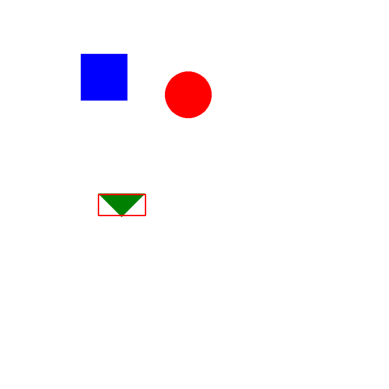

In [17]:
def test_detect_objects_in_first_test_image_with_original_detr_resnet_50_model():
    inference_image_processor: DetrImageProcessor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
    inference_model: DetrForObjectDetection = AutoModelForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
    test_img: Image = ds['test'][0]['image']
    detection_result: typing.Dict = detect_objects(test_img, inference_image_processor, inference_model, threshold=0.1)

test_detect_objects_in_first_test_image_with_original_detr_resnet_50_model()

The threshold has to be dropped to 0.1 to get just 1 detected object: apparently the triangle looks a bit like a kite.

The original facebook/detr-resnet-50 model is clearly not meant to be used to detect basic shapes in an image.

I've run this notebook also on a system with an NVIDIA V100 GPU. All the code is the same, except the training code is slightly different:

```
finetuned_model_dir_nvidia_v100: str = 'facebook-detr-resnet-50-finetuned-for-basic-shapes-on-nvidia-v100'

training_args_single_image: TrainingArguments = TrainingArguments(
    output_dir=finetuned_model_dir_nvidia_v100,
    overwrite_output_dir=True,
    do_train=True,
    per_device_train_batch_size=16,
    num_train_epochs=20,
    fp16=False, # only available on GPUs
    save_steps=50,
    logging_steps=20,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
)
```
Training took only 34 minutes to reach a training loss of 0.3, which is quite a bit lower than what my MacBook Pro could reach after 2 and a half hour of calculations.

I've copied the 'facebook-detr-resnet-50-finetuned-for-basic-shapes-on-nvidia-v100' directory so I could test the result within this notebook:

MPS is available: using Apple Silicon GPU
width: 800, height: 800
Number of detected objects at threshold level 0.5: 3
Category Triangle with score 0.56 at bounding box 191,398,99,49
Category Square with score 0.70 at bounding box 153,96,98,99
Category Circle with score 0.70 at bounding box 335,134,98,100


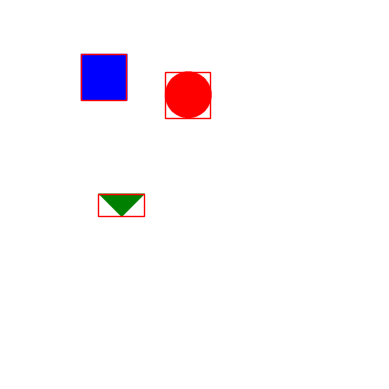

In [10]:
finetuned_model_dir_nvidia_v100: str = "facebook-detr-resnet-50-finetuned-for-basic-shapes-on-nvidia-v100"

def test_detect_objects_in_first_test_image_with_finetuned_model_on_nvidia_v100():
    inference_image_processor: DetrImageProcessor = AutoImageProcessor.from_pretrained(finetuned_model_dir_nvidia_v100)
    inference_model: DetrForObjectDetection = AutoModelForObjectDetection.from_pretrained(finetuned_model_dir_nvidia_v100)
    test_img: Image = ds['test'][0]['image']
    detection_result: typing.Dict = detect_objects(test_img, inference_image_processor, inference_model, threshold=0.5)

test_detect_objects_in_first_test_image_with_finetuned_model_on_nvidia_v100()

The confidence levels are higher and the bounding box of the circle is better positioned. 

Final step: push the model to HuggingFace Hub. The pushed model is the one fine-tuned on a V100.

In [12]:
import huggingface_hub

def push_model_to_huggingface_hub():
    model: DetrForObjectDetection = AutoModelForObjectDetection.from_pretrained(finetuned_model_dir_nvidia_v100)
    hf_token: typing.Optional[str] = huggingface_hub.HfFolder.get_token()
    if hf_token is None:
        print("You first need to login to use the HugginFace hub")
    else:
        model.push_to_hub(repo_id='driesverachtert/basic_shapes_object_detection', private=False, token=hf_token)

    readme_file: str = "README.md"
    readme_contents: str
    with open(readme_file, 'r') as file:
        readme_contents = file.read()
    card = huggingface_hub.repocard.RepoCard(readme_contents)
    card.push_to_hub('driesverachtert/basic_shapes_object_detection', token=hf_token, repo_type="model")

push_model_to_huggingface_hub()

README.md:   0%|          | 0.00/11.0 [00:00<?, ?B/s]

The load on my macbook pro during training:

![GPUs fully used](macbook-pro-load-during-training.png)